## premise: Grid search for clustering solution

via skleanr pipeline and grid search

utilize a distribution across known bins, to normalize the output variable

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

In [2]:
# QQ plot and normality testing features, pre cluster search
import math
import numpy as np
from scipy.stats import lognorm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
#load pipeline 1 csv and prep for clustering
m2_pipeline = pd.read_csv('pipeline1.csv')
#change is surge price rate of change per observation, change.1 is precursor
#sum_change is surge sum_change per surge, and surge_area is surge alone
# keepable = ['precursor_buy_cap_pct_change', 
#             'precursor_ask_cap_pct_change',
#             'precursor_bid_vol_pct_change', 
#             'precursor_ask_vol_pct_change', 'change.1',
#             'surge_targets_met_pct']

keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length',
            'surge_targets_met_pct']

# Normalize the 'surge_targets_met_pct' column
x = m2_pipeline[['surge_targets_met_pct']].values.astype(float)
m2_pipeline = m2_pipeline[keepable]
print(m2_pipeline.isna().sum(axis=1).astype(bool).sum())
m2_pipeline = m2_pipeline.astype('float')
m2_pipeline.dtypes

0


precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                          float64
surge_targets_met_pct           float64
dtype: object

### distribution of features, pre scale and transformation

IndexError: index 2 is out of bounds for axis 0 with size 2

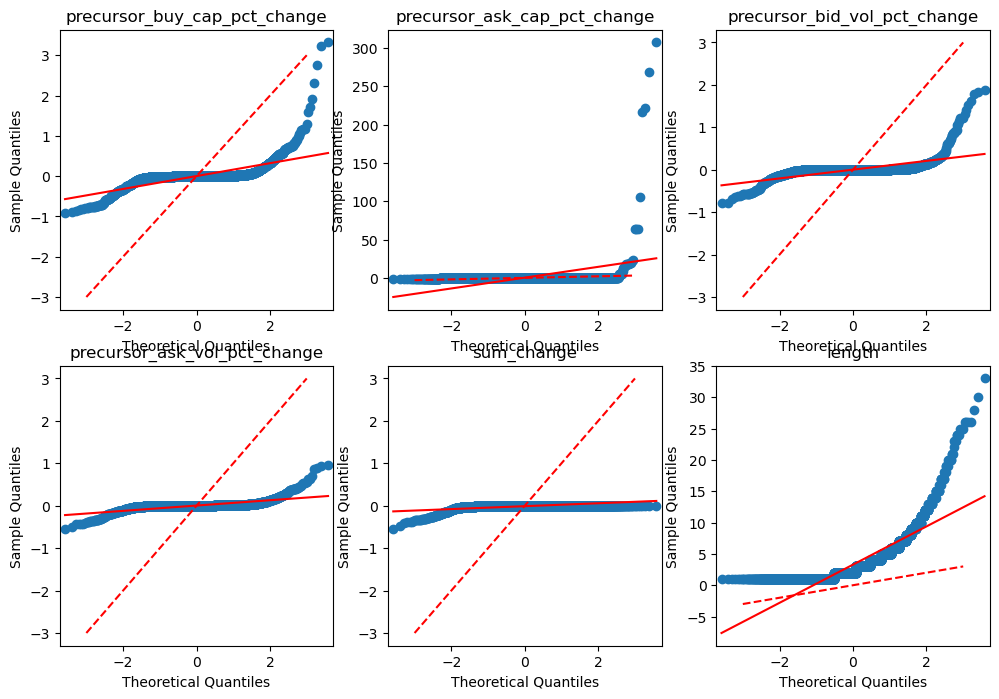

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming you have loaded your data into a variable named 'm2_pipeline'
columns_to_normalize = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length',
            'surge_targets_met_pct']

# = [
#     'precursor_buy_cap_pct_change',
#     'precursor_ask_cap_pct_change',
#     'precursor_bid_vol_pct_change',
#     'precursor_ask_vol_pct_change',
#     'change.1',
#     'surge_targets_met_pct'
# ]

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over each column and create a QQ plot in each subplot
for i, column_name in enumerate(columns_to_normalize):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Retrieve the column data from the 'm2_pipeline' DataFrame
    column_data = m2_pipeline[column_name]
    
    # Create a QQ plot in the current subplot
    sm.qqplot(column_data, line='s', ax=ax)
    ax.plot([-3, 3], [-3, 3], color='red', linestyle='--')

    # Set the title for the current subplot
    ax.set_title(column_name)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the grid of QQ plots
plt.show()

Skewness:
precursor_buy_cap_pct_change     5.487709
precursor_ask_cap_pct_change    34.783225
precursor_bid_vol_pct_change     6.709834
precursor_ask_vol_pct_change     3.223206
sum_change                      -7.162200
length                           2.907762
surge_targets_met_pct            0.907975
dtype: float64

Normality:
precursor_buy_cap_pct_change    False
precursor_ask_cap_pct_change    False
precursor_bid_vol_pct_change    False
precursor_ask_vol_pct_change    False
sum_change                      False
length                          False
surge_targets_met_pct           False
dtype: bool


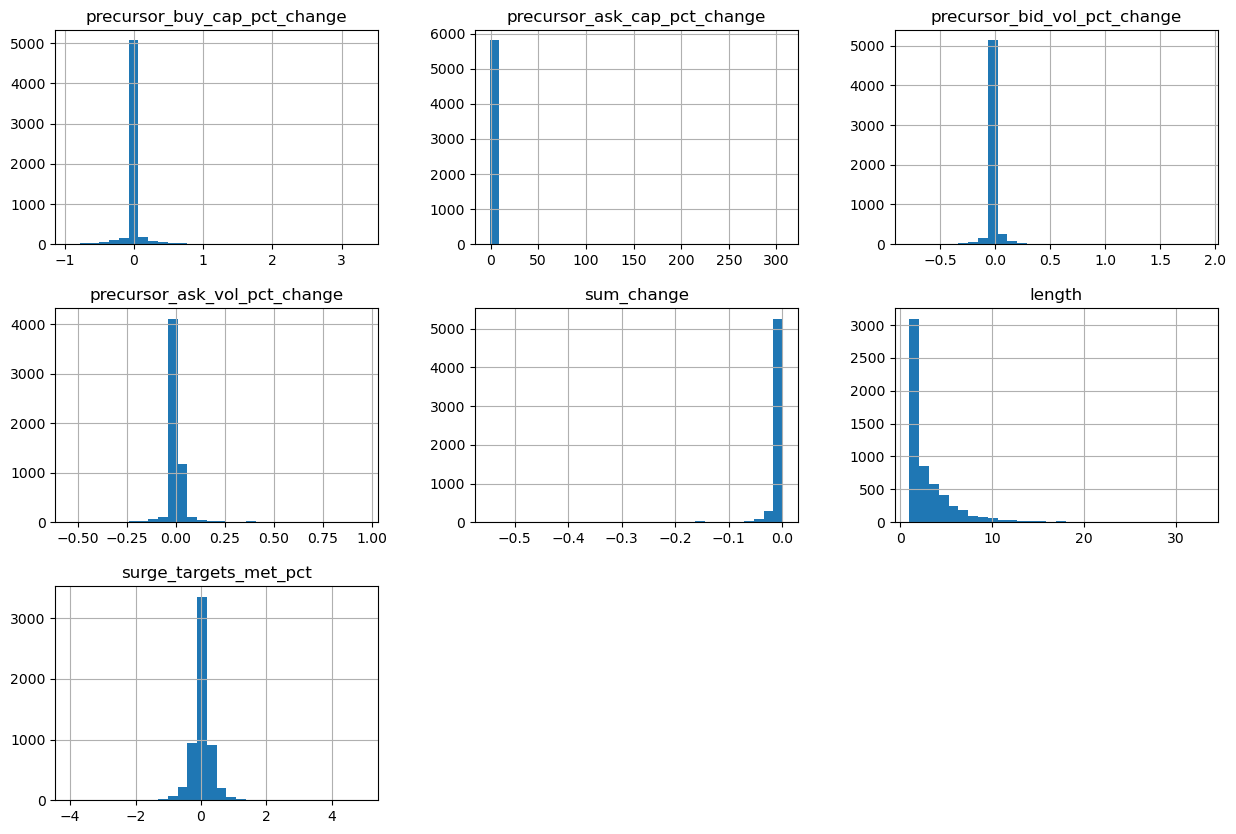

In [7]:
# Create histograms for each column
m2_pipeline.hist(bins=30, figsize=(15, 10))

# Determine skew and normality for each column
skewness = m2_pipeline.skew()
normality = skewness.abs() < 0.5

print(f'Skewness:\n{skewness}\n\nNormality:\n{normality}')

## using predefined bins for discrete clustering

In [8]:
# bins = [float(f"{x:.2f}") for x in range(-10, 11)]
# bins = [x * 0.2 for x in range(-10, 11)]
# print(bins)
# #model 
# m2_pipeline['bin'] = pd.cut(m2_pipeline['surge_targets_met_pct'], bins=bins  )#, labels=labels)
# # Display the binned data
# print(m2_pipeline['bin'].value_counts())
# m2_pipeline['bin']

bins = [
    m2_pipeline['surge_targets_met_pct'].min() -1,  # Min value  # -4 to 0 divided into three equal parts
    -4/3,# Second bin edge for negative values
    -4/6,
    -4/12,
    0,
    0.125,
    0.25, 0.5, 0.75, 1,  # Four bins between 0 and 1
    2,  # One bin between 1 and 2
    m2_pipeline['surge_targets_met_pct'].max() + 1]
bin_labels = list(range(1, len(bins)))

In [9]:
for i in range(1, len(bins)):
    print(f'Bin {bin_labels[i-1]}: {bins[i-1]:.2f} - {bins[i]:.2f}')

Bin 1: -5.01 - -1.33
Bin 2: -1.33 - -0.67
Bin 3: -0.67 - -0.33
Bin 4: -0.33 - 0.00
Bin 5: 0.00 - 0.12
Bin 6: 0.12 - 0.25
Bin 7: 0.25 - 0.50
Bin 8: 0.50 - 0.75
Bin 9: 0.75 - 1.00
Bin 10: 1.00 - 2.00
Bin 11: 2.00 - 5.97


In [10]:
m2_pipeline['label'] = pd.cut(m2_pipeline['surge_targets_met_pct'], bins=bins, labels=bin_labels)

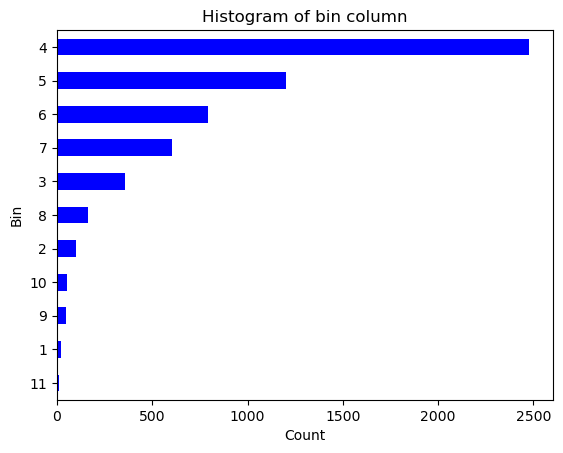

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a variable named 'm2_pipeline'
bin_counts = m2_pipeline['label'].value_counts()

# Create a horizontal bar plot of the value counts
ax = bin_counts.plot(kind='barh', color=['red' if count < 0 else 'blue' for count in bin_counts])

# Reverse the y-axis
ax.invert_yaxis()

# Set the title and axis labels
plt.title('Histogram of bin column')
plt.xlabel('Count')
plt.ylabel('Bin')

# Display the plot
plt.show()


### profitability of binning scheme

does it identify adequate numbers of profitable (ie fully tradeable) precursors in the market.

In [14]:
bin_counts

4     2479
5     1201
6      794
7      603
3      358
8      164
2      100
10      50
9       46
1       20
11      11
Name: label, dtype: int64

In [12]:
m2_pipeline.dtypes

precursor_buy_cap_pct_change     float64
precursor_ask_cap_pct_change     float64
precursor_bid_vol_pct_change     float64
precursor_ask_vol_pct_change     float64
sum_change                       float64
length                           float64
surge_targets_met_pct            float64
label                           category
dtype: object

https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling

## NORMALIZE FEATURES TEST

study the value distribution impact of normalizing features

In [ ]:
# # List of columns to normalize
# # SCAL3E WITH STANDARD SCALE ONCE YOU DIVDE INTO TEST TRAIN
# columns_to_normalize = ['precursor_buy_cap_pct_change', 
#             'precursor_ask_cap_pct_change',
#             'precursor_bid_vol_pct_change', 
#             'precursor_ask_vol_pct_change',
#             'sum_change',
#             'length',
#             'surge_targets_met_pct']

# # Create a StandardScaler object
# scaler = StandardScaler()
# m2_pipline_scaled = scaler.fit_transform(m2_pipeline[columns_to_normalize])
# # Iterate over the list of columns and normalize each column
# for column in columns_to_normalize:
#     m2_pipeline[column] = scaler.fit_transform(m2_pipeline[[column]])

In [ ]:
# # Select columns to normalize
# columns_to_normalize = ['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change',
#                         'precursor_bid_vol_pct_change', 'precursor_ask_vol_pct_change',
#                         'sum_change', 'length', 'surge_targets_met_pct']
# data_to_normalize = m2_pipeline[columns_to_normalize]

# # Create a MinMaxScaler object and fit it to the data
# scaler = StandardScaler()
# scaler.fit(data_to_normalize)

# # Transform the data using the scaler
# normalized_data = scaler.transform(data_to_normalize)

# # Replace the original columns with the normalized data
# m2_pipeline[columns_to_normalize] = normalized_data

### apply normalization to features
from [scipi], (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [ ]:
# print("for column:")
# for column in columns_to_normalize:
#     # stat, p = shapiro(m2_pipeline[column])
#     print(column,shapiro(m2_pipeline[column]))
#     # print(column, f"Test statistic: {stat} p-Value: {p}")

In [ ]:
# from scipy import stats
# # df = pd.DataFrame(np.random.normal(0,1,2100).reshape(100,21)) # dataset (100x21)
# # from https://stackoverflow.com/a/60709956
# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# k2, p = stats.normaltest(m2_pipeline[columns_to_normalize])
# print (k2, p)

In [ ]:
# # Create histograms for each column
# m2_pipeline.hist(bins=30, figsize=(15, 10))
# for column in columns_to_normalize:
#     m2_pipeline[column] = scaler.fit_transform(m2_pipeline[[column]])
# # Determine skew and normality for each column
# skewness = m2_pipeline.skew()
# normality = skewness.abs() < 0.5

# print(f'Skewness:\n{skewness}\n\nNormality:\n{normality}')

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import statsmodels.api as sm

# # Assuming you have loaded your data into a variable named 'm2_pipeline'
# columns_to_normalize = ['precursor_buy_cap_pct_change', 
#             'precursor_ask_cap_pct_change',
#             'precursor_bid_vol_pct_change', 
#             'precursor_ask_vol_pct_change',
#             'sum_change',
#             'length',
#             'surge_targets_met_pct']

# # = [
# #     'precursor_buy_cap_pct_change',
# #     'precursor_ask_cap_pct_change',
# #     'precursor_bid_vol_pct_change',
# #     'precursor_ask_vol_pct_change',
# #     'change.1',
# #     'surge_targets_met_pct'
# # ]

# # Create a grid of subplots
# fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# # Iterate over each column and create a QQ plot in each subplot
# for i, column_name in enumerate(columns_to_normalize):
#     row = i // 3
#     col = i % 3
#     ax = axes[row, col]
    
#     # Retrieve the column data from the 'm2_pipeline' DataFrame
#     column_data = m2_pipeline[column_name]
    
#     # Create a QQ plot in the current subplot
#     sm.qqplot(column_data, line='s', ax=ax)
#     ax.plot([-3, 3], [-3, 3], color='red', linestyle='--')

#     # Set the title for the current subplot
#     ax.set_title(column_name)

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Display the grid of QQ plots
# plt.show()


## Grid Search clustering techniques

In [ ]:
# #SPECIFIED CLUSTER DISCOVERY
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# # from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
# from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering,\
# MeanShift, AffinityPropagation, DBSCAN, OPTICS, Birch
# from sklearn.metrics import silhouette_score
# m2_pipeline = m2_pipeline.dropna()

# # Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['bin'])
# y = m2_pipeline['bin']

# # Performing the test/train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# #DO STANDARDIZATION ONCE YOU DO TEST TRAIN NOT BEFORE 
# def silhouette_scorer(estimator, X, y=None):
#     labels = estimator.fit_predict(X)
#     score = silhouette_score(X, labels)
#     return score
# # Defining the parameter grid for GridSearchCV
# param_grid = {'n_clusters': [2,3,4,5,6,7,8,9,10]}  #'algorithm': ['auto', 'full', 'elkan']

# clustering_models = [
#     ('KMeans', KMeans()),
#     ('SpectralClustering', SpectralClustering()),
#     ('Birch', Birch()),
# ('Hierarchical',AgglomerativeClustering())]
# # Performing GridSearchCV for each clustering model
# for model_name, model in clustering_models:
#     grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer)
#     grid_search.fit(X_train, y_train)
#     # Evaluating the best model based on silhouette score
#     best_model = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     print(f'{model_name}:')
#     print(f'Best parameters: {grid_search.best_params_}')
#     print(f'Silhouette score (train): {best_score:.4f}')
#     print(f'Silhouette score (test): {best_score:.4f}')

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# # from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
# from sklearn.cluster import MeanShift, AffinityPropagation, DBSCAN, OPTICS
# from sklearn.metrics import silhouette_score
# # Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['bin'])
# y = m2_pipeline['bin']
# # Performing the test/train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# def silhouette_scorer(estimator, X, y=None):
#     labels = estimator.fit_predict(X)
#     score = silhouette_score(X, labels)
#     return score

# param_grid = {}  #'algorithm': ['auto', 'full', 'elkan']
# clustering_models = [
#     ('Meanshift',  MeanShift( bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)),
#     ('AffinityPropagation', AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state=42)),
#     ('DBSCAN', DBSCAN(eps=0.5,  min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)),
# ('OPTICS', OPTICS( min_samples=5, max_eps=3, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, memory=None, n_jobs=None))]
# # Performing GridSearchCV for each clustering model
# for model_name, model in clustering_models:
#     grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer)
#     grid_search.fit(X_train, y_train)
#     # Evaluating the best model based on silhouette score
#     best_model = grid_search.best_estimator_
#     best_score = grid_search.best_score_
#     print(f'{model_name}:')
#     # print(f'Best parameters: {grid_search.best_params_}')
#     print(f'Silhouette score (train): {best_score:.4f}')
#     print(f'Silhouette score (test): {best_score:.4f}')

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import accuracy_score
# X = m2_pipeline.drop(columns=['bin'])
# y = m2_pipeline['bin']
# # Splitting the dataset into train and test sets

# #USE STANDARD SCALING ONCE YOU DIVDE TEST AND TRAIN NOT BEFORE
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Creating an instance of SpectralClustering
# model = SpectralClustering(n_clusters=7)

# # Fitting the model to the training data
# model.fit_predict(X_train)

# # Predicting labels for the testing data
# y_pred = model.predict(X_test)

# # Calculating the accuracy score
# accuracy = accuracy_score(y_test, y_pred)


## notes 

1. grid search notes on [sklearn](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
2. sklearn pipeline [guide](https://scikit-learn.org/stable/modules/compose.html#pipeline)